In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Data Loading

In [2]:
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')

In [3]:
X = data['Translated']
y = data['Label']

In [4]:
X

0      After hacking state TV by replacing propaganda...
1      #flowers #lovers\nMake love not war.\nMarc Cha...
2      If only we all showed more love and understand...
3      Who are the soldiers we see in the videos? Are...
4      I didn't think #Salvini could make his positio...
                             ...                        
475    If I write that Ms. #Zelensky was allegedly sp...
476    #Zelensky and his wife #OlenaZelenska bought a...
477    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
478    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
479    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
Name: Translated, Length: 480, dtype: object

In [5]:
y

0      1
1      2
2      2
3      2
4      1
      ..
475    1
476    0
477    2
478    2
479    2
Name: Label, Length: 480, dtype: int64

# Pretrained not Finetuned

## Load Bert

In [72]:
pretrained_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

## Generate Embeddings

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

def generate_sentence_embeddings(texts, tokenizer, model, batch_size=32):
    """
    Generate BERT embeddings for a list of sentences.

    Args:
        texts (list of str): List of input sentences.
        tokenizer: Pre-trained BERT tokenizer.
        model: Pre-trained BERT model.
        batch_size (int): Batch size for processing.
        device (str): Device to use ('cpu' or 'cuda').

    Returns:
        np.ndarray: Array of sentence embeddings (shape: [num_sentences, embedding_dim]).
    """
    model.to(device)
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)
            outputs = model(**inputs)
            pooled_output = outputs.pooler_output.cpu().numpy()
            embeddings.append(pooled_output)
    return np.vstack(embeddings)

In [99]:

# Split the data while preserving raw text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate embeddings for training and testing sets
print("Generating BERT embeddings...")
X_train_embeddings = generate_embeddings(X_train.tolist(), pretrained_tokenizer, pretrained_model)
X_test_embeddings = generate_embeddings(X_test.tolist(), pretrained_tokenizer, pretrained_model)

print('Done')

Generating BERT embeddings...
Done


## Train an SVM

In [100]:
print("Training SVM...")
clf = SVC(kernel='linear')
clf.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Training SVM...
Accuracy: 41.67%


## View report

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.50      0.48        16
           1       0.17      0.20      0.18        20
           2       0.53      0.60      0.57        43
           3       0.33      0.12      0.17        17

    accuracy                           0.42        96
   macro avg       0.38      0.36      0.35        96
weighted avg       0.41      0.42      0.40        96



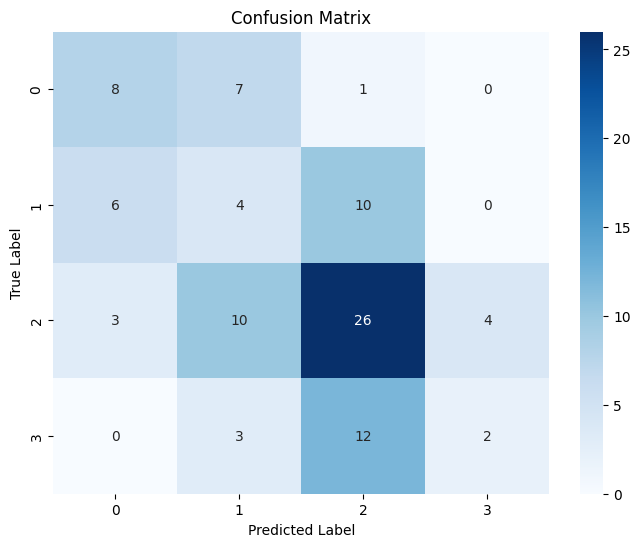

In [101]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get unique class labels for plotting
class_labels = sorted(set(y_test))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## See misclassified sentences

In [78]:
misclassified_indices = np.where(y_test != y_pred)[0]

# Print misclassified sentences
print("Misclassified Sentences:")
for idx in misclassified_indices:
    print()
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}, Sentence: {X_test.iloc[idx]}")
    print('---')

Misclassified Sentences:

True Label: 3, Predicted Label: 2, Sentence: From symbol of peace to megaphone for war, #Putin rewrites history of #Luzniki stadium
---

True Label: 1, Predicted Label: 2, Sentence: Countries supporting #Ukraine do not have the means to track the weapons they send to the Kiev army. And some have already gone to pro-Russian troops in the #Donbass, as some photos show 👇

by @FuturaDaprile

 
---

True Label: 1, Predicted Label: 0, Sentence: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
Sveglia!!!
#StopTheWar
#DraghiVatteneSubito
#NonInMioNome
---

True Label: 2, Predicted Label: 1, Sentence: This #April25 I will go to the parade.
I had the honor of knowing that generation of #Liberals who took up arms to defend the Fatherland, and I know they would have no problem today recognizing the #partisans of that time in the Ukrainians and Ukrainians of

## Visualize the embeddings of the individual words

In [105]:
def generate_word_embeddings(text, tokenizer, model, device='cpu'):

    model.to(device)
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state  # Shape: (1, num_tokens, 768)
        embeddings = hidden_states.squeeze(0).cpu().numpy()  # Shape: (num_tokens, 768)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return tokens, embeddings

def plot_word_embeddings(tokens, embeddings, reduction_method='pca'):

    # Step 1: Reduce dimensions to 2D
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(5, len(tokens) - 1))
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    else:
        raise ValueError("Invalid reduction method. Choose 'pca' or 'tsne'.")

    # Step 2: Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)

    # Annotate each point with its token
    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

    plt.xlabel(f'{reduction_method.upper()} Component 1')
    plt.ylabel(f'{reduction_method.upper()} Component 2')
    plt.title(f'2D Word Embedding Visualization ({reduction_method.upper()})')
    plt.grid()
    plt.show()

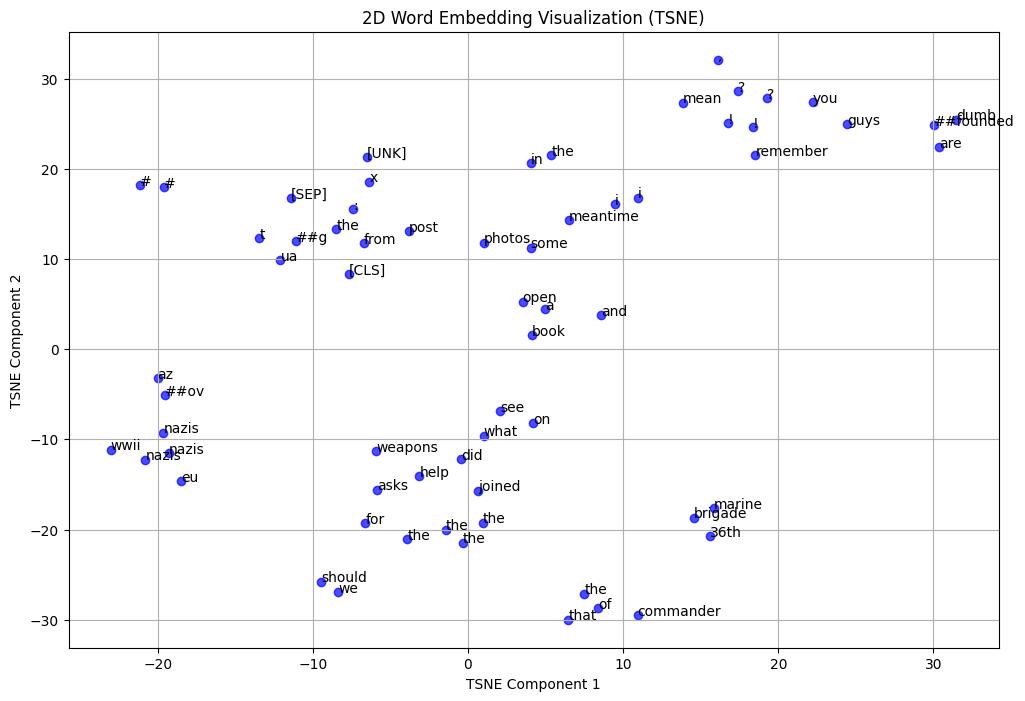

In [106]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
text = """From the #TG: UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱
Are you guys dumbfounded?
Open a book on WWII and see what the Nazis did! In the meantime I post some photos x remember"""
tokens, embeddings = generate_word_embeddings(text, pretrained_tokenizer, pretrained_model, device=device)
plot_word_embeddings(tokens, embeddings, reduction_method='tsne')

## Visualize the Embeddings

In [103]:
def plot_attention_scores(sentence, tokenizer, model, device='cpu', layer=0, head=0):

    # Step 1: Move the model to the specified device
    model.to(device)
    model.eval()

    # Step 2: Tokenize the input sentence
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )

    # Step 3: Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Step 4: Generate attention scores
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Tuple of attention tensors for all layers and heads

    # Step 5: Extract attention scores for the specified layer and head
    # Average attention scores across all heads in a layer
    attention_scores = attentions[layer].mean(dim=1)[0].cpu().numpy()
    
    # Average attention scores across all layers and heads
    attention_scores = torch.stack(attentions).mean(dim=(1, 2))[0].cpu().numpy()

    # Step 6: Get tokens for labeling
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Step 7: Plot attention scores as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_scores, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f"Attention Scores (Layer {layer}, Head {head})")
    plt.xlabel("Keys (Tokens)")
    plt.ylabel("Queries (Tokens)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

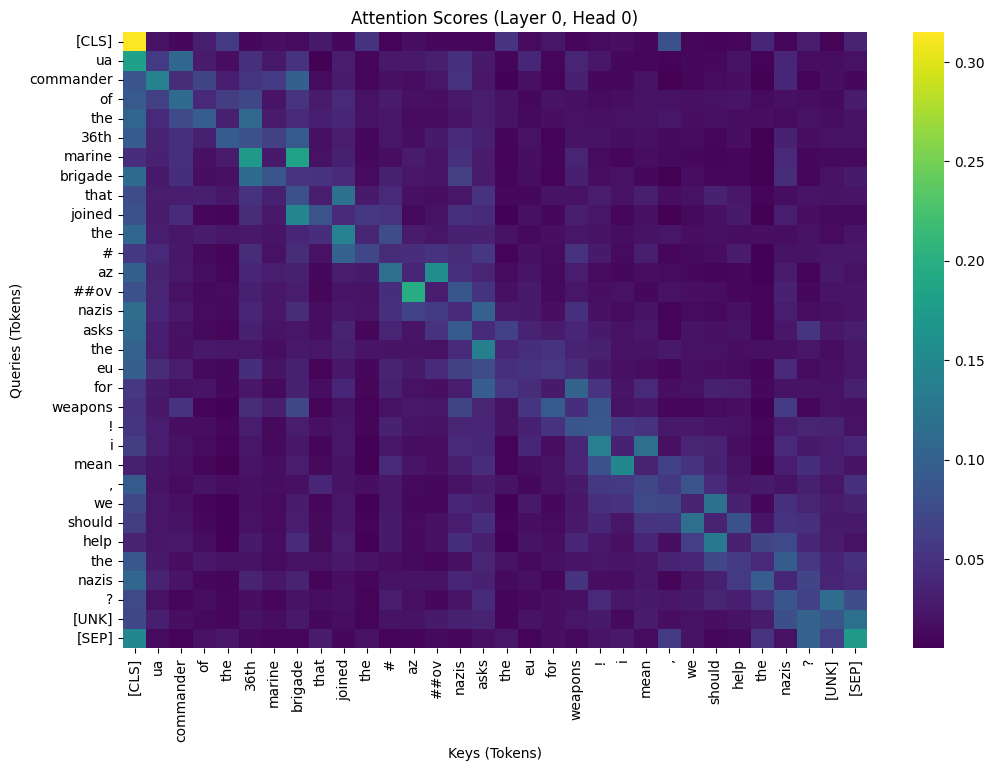

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sentence =""" UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
plot_attention_scores(sentence, pretrained_tokenizer, pretrained_model, device=device, layer=0, head=0)

# ChatGPT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts.iloc[index]  # Using .iloc for safe indexing
        label = self.labels.iloc[index]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Define Model
class BERTClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        return logits

# Prepare Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Model and Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training Loop
def train_model(epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation
def evaluate_model():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Run Training and Evaluation
train_model(25)
evaluate_model()


In [ ]:
import os

def save_model(model, path='/kaggle/working/model_state_dict.pt'):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model state dict saved to {path}")


In [ ]:
save_model(model)

In [ ]:
def save_tokenizer(tokenizer, path='/kaggle/working/tokenizer'):
    os.makedirs(path, exist_ok=True)
    tokenizer.save_pretrained(path)
    print(f"Tokenizer saved to {path}")


In [ ]:
save_tokenizer(tokenizer)

In [ ]:
import numpy as np

def generate_embeddings(texts, tokenizer, model, batch_size=16, max_len=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            
            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)

            # If pooler_output is available, use it; otherwise, use mean of last hidden state
            if hasattr(outputs, 'pooler_output'):
                batch_embeddings = outputs.pooler_output.cpu().numpy()
            else:
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

            embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are available
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_embeddings(X_test.tolist(), tokenizer, model)

# Train the SVM
svm_classifier = SVC(kernel='linear', class_weight = 'balanced')
svm_classifier.fit(X_train_embeddings, y_train)

# Predict and Evaluate
y_pred = svm_classifier.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy with SVM: {accuracy * 100:.2f}%")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Predict using SVM
y_pred = svm_classifier.predict(X_test_embeddings)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
if len(set(y_test)) <= 2:
    auc_score = roc_auc_score(y_test, svm_classifier.decision_function(X_test_embeddings))
    print(f"AUC-ROC Score: {auc_score:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, svm_classifier.decision_function(X_test_embeddings))
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("AUC-ROC is not applicable for multi-class classification.")


In [ ]:
print('hi')

In [ ]:
misclassified_indices = np.where(y_test != y_pred)[0]
for idx in misclassified_indices[:10]:  # Inspect first 10 misclassified samples
    print(f"Text: {X_test.iloc[idx]}")
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}\n")

# Early Stopping

In [ ]:
class BERTClassifierWithAttention(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTClassifierWithAttention, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        
        # Extract attention weights (already normalized)
        attentions = outputs.attentions  # Tuple of attention weights for each layer
        
        # Compute attention scores (unnormalized)
        attention_scores = []
        for layer in self.bert.encoder.layer:
            attn = layer.attention.self
            q = attn.query(input_ids)
            k = attn.key(input_ids)
            scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
            attention_scores.append(scores.detach())  # Store unnormalized scores
        
        return logits, attentions, attention_scores

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_scores(scores, title="Attention Scores"):
    # Normalize scores for visualization
    scores = scores[0].detach().numpy()  # Shape: (num_heads, seq_len, seq_len)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores[0], annot=True, fmt=".2f", cmap="viridis")  # First head
    plt.title(title)
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

# Attention

## Initialize bert and set output attentions to True

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BERTClassifierWithAttention(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTClassifierWithAttention, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        
        # Extract attention weights (normalized scores)
        attentions = outputs.attentions  # Tuple of attention weights for each layer
        
        # Extract Q, K, V matrices manually
        qkv_values = []
        for layer in self.bert.encoder.layer:
            attn = layer.attention.self
            q = attn.query(outputs.last_hidden_state)  # Query projection
            k = attn.key(outputs.last_hidden_state)    # Key projection
            v = attn.value(outputs.last_hidden_state)  # Value projection
            qkv_values.append((q.detach(), k.detach(), v.detach()))
        
        return logits, attentions, qkv_values

## Load the dataset and set up the finetuning environment

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts.tolist() if hasattr(texts, 'tolist') else texts
        self.labels = labels.tolist() if hasattr(labels, 'tolist') else labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifierWithAttention(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

## Train it
> Run a few epochs on our dataset

In [ ]:
# Training Loop
def train_model(epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits, _, _ = model(input_ids, attention_mask)  # Ignore attentions and QKV during training
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Run Training
train_model(epochs=20)



## Generate Embeddings from finetuned model

In [ ]:
def generate_embeddings(texts, tokenizer, model, batch_size=16, max_len=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            
            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.pooler_output.cpu().numpy()  # Use pooler_output
            embeddings.extend(batch_embeddings)
    
    return embeddings

# Generate embeddings for train and test sets
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_val_embeddings = generate_embeddings(X_val.tolist(), tokenizer, model)

## Save model

## Classify embeddings using SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_embeddings, y_train)

# Predict and Evaluate
y_pred = svm_classifier.predict(X_val_embeddings)
accuracy = accuracy_score(y_val, y_pred)

print(f"Validation Accuracy with SVM: {accuracy * 100:.2f}%")

## Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_pred))

## Analyze misclassified

In [ ]:
misclassified_indices = np.where(y_val != y_pred)[0]
for idx in misclassified_indices[:10]:  # Inspect first 10 misclassified samples
    print(f"Text: {X_val.iloc[idx]}")
    print(f"True Label: {y_val.iloc[idx]}, Predicted Label: {y_pred[idx]}\n")

## Extract attentions and Q, K and V values

In [ ]:
def extract_attention_and_qkv(model, tokenizer, text):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        _, attentions, qkv_values = model(input_ids, attention_mask)
    
    return attentions, qkv_values

# Example usage
text = """
#RussiansAreOurBrothers #UkrainiansAreOurBrothers.
"""
attentions, qkv_values = extract_attention_and_qkv(model, tokenizer, text)

# Inspect Q, K, V values for the first layer
q, k, v = qkv_values[0]
print("Query Matrix:", q)
print("Key Matrix:", k)
print("Value Matrix:", v)

In [ ]:
print(attentions)

## Visualizing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

def generate_word_embeddings(text, tokenizer, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state.cpu().numpy()[0]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return tokens, last_hidden_state

def plot_word_embeddings(tokens, embeddings):
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue')

    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('2D Word Embedding Visualization')
    plt.grid()
    plt.show()

# Example usage
text = "#RussiansAreOurBrothers #UkrainiansAreOurBrothers."
tokens, embeddings = generate_word_embeddings(text, tokenizer, model)
plot_word_embeddings(tokens, embeddings)


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load non-finetuned BERT model and tokenizer
non_finetuned_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
non_finetuned_model = BertModel.from_pretrained('bert-base-uncased')

def generate_non_finetuned_embeddings(text, tokenizer, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, add_special_tokens=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.squeeze(0).cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())
    return embeddings, tokens

def plot_embeddings_with_labels(embeddings, tokens, title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o', c='blue')

    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

# Example text
text = "#RussiansAreOurBrothers #UkrainiansAreOurBrothers."

# Generate and plot embeddings for non-finetuned BERT
non_finetuned_embeddings, tokens = generate_non_finetuned_embeddings(text, non_finetuned_tokenizer, non_finetuned_model)
plot_embeddings_with_labels(non_finetuned_embeddings, tokens, 'Non-Finetuned BERT Embeddings with Annotations')


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_scores(attentions, layer_idx=0, head_idx=0):
    """
    Plots attention scores for a specific layer and head.
    """
    # Extract attention weights for the specified layer and head
    attention_weights = attentions[layer_idx][0, head_idx].detach().cpu().numpy()  # Shape: (seq_len, seq_len)
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"Attention Scores (Layer {layer_idx}, Head {head_idx})")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

### Markdown

In [ ]:

# Plot attention scores for the first layer and first head
plot_attention_scores(attentions, layer_idx=0, head_idx=0)

### Query Values

In [ ]:
def plot_query_values(q, tokenized_text, layer_idx=0, head_idx=0):
    """
    Plots query values for a specific layer and head.
    """
    # Extract query values for the specified layer and head
    q_values = q[layer_idx][0, :, head_idx].detach().cpu().numpy()  # Shape: (seq_len,)
    
    # Decode tokenized text
    tokens = tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0])
    
    # Plot bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(tokens, q_values, color='skyblue')
    plt.title(f"Query Values (Layer {layer_idx}, Head {head_idx})")
    plt.xlabel("Tokens")
    plt.ylabel("Query Value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_qkv_matrix_with_tokens(matrix, tokens, title="Matrix", cmap="viridis"):
    """
    Plots a heatmap of the given Q, K, or V matrix with token labels.
    """
    # Convert matrix to numpy array if it's a PyTorch tensor
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.detach().cpu().numpy()
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(matrix, cmap=cmap, yticklabels=tokens)
    plt.title(title)
    plt.xlabel("Hidden Dimensions")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()

In [ ]:



# Tokenize the input text
text = """
#RussiansAreOurBrothers #UkrainiansAreOurBrothers.
"""
encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

# Extract tokens
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])  # List of tokens
print("Tokens:", tokens)

In [ ]:
# Extract attention scores and Q, K, V values
attentions, qkv_values = extract_attention_and_qkv(model, tokenizer, text)

# Inspect Q, K, V values for the first layer
q, k, v = qkv_values[0]
print("Query Matrix Shape:", q.shape)
print("Key Matrix Shape:", k.shape)
print("Value Matrix Shape:", v.shape)

In [ ]:
# Move tensors to CPU and convert to numpy arrays
q_matrix = q[0, 0].detach().cpu().numpy()  # Shape: (seq_len, head_dim)
k_matrix = k[0, 0].detach().cpu().numpy()  # Shape: (seq_len, head_dim)
v_matrix = v[0, 0].detach().cpu().numpy()  # Shape: (seq_len, head_dim)

print("Query Matrix Shape:", q_matrix.shape)
print("Key Matrix Shape:", k_matrix.shape)
print("Value Matrix Shape:", v_matrix.shape)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_scores(attentions, tokens, layer_idx=0, head_idx=0):
    """
    Plots attention scores for a specific layer and head with tokens as labels.
    attentions: Attention weights from BERT output (shape: [layers, batch, heads, seq_len, seq_len])
    tokens: Tokenized input (list of token strings)
    layer_idx: Index of the layer to visualize
    head_idx: Index of the head to visualize
    """
    # Extract attention weights for the specified layer and head
    attention_weights = attentions[layer_idx][0, head_idx].detach().cpu().numpy()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        attention_weights, 
        annot=True, 
        fmt=".2f", 
        cmap="viridis",
        xticklabels=tokens, 
        yticklabels=tokens
    )
    plt.title(f"Attention Scores (Layer {layer_idx}, Head {head_idx})")
    plt.xlabel("Keys (Words being attended to)")
    plt.ylabel("Queries (Words attending)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Example usage
# Assuming `attentions` is the attention tensor from BERT and `tokens` is the tokenized input
plot_attention_scores(attentions, tokens, layer_idx=0, head_idx=0)
